<a href="https://colab.research.google.com/github/mymess/Bitcoin-nodes-globe/blob/master/Training_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Having a good understanding of how things work can help us quickly home in on the
appropriate model, the right training algorithm to use, and a good set of hyperparameters for our task.

Understanding what’s under the hood will also help us debug issues and perform error analysis more
efficiently. Lastly, most of the topics discussed in this chapter will be essential in understanding, building,
and training neural networks.

In this section, we will start by looking at the Linear Regression model, one of the simplest models there
is. We will discuss two very different ways to train it:

*   Using a direct “closed-form” equation that directly computes the model parameters that best fit the model to the training set (i.e., the model parameters that minimize the cost function over the training
set).

*   Using an iterative optimization approach, called Gradient Descent (GD), that gradually tweaks the
model parameters to minimize the cost function over the training set, eventually converging to the
same set of parameters as the first method. We will look at a few variants of Gradient Descent that
we will use again and again when we study neural networks in Part II: Batch GD, Mini-batch GD,
and Stochastic GD.


Next we will look at Polynomial Regression, a more complex model that can fit nonlinear datasets. Since
this model has more parameters than Linear Regression, it is more prone to overfitting the training data,
so we will look at how to detect whether or not this is the case, using learning curves, and then we will
look at several regularization techniques that can reduce the risk of overfitting the training set.

Finally, we will look at two more models that are commonly used for classification tasks: Logistic
Regression and Softmax Regression.

#Setup

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

#1. Linear Regression

A linear model makes a prediction by simply computing a weighted sum of the input
features, plus a constant called the bias term (also called the intercept term), as follows:

**TODO: add equations**

Let's generate a random linear dataset and plot it:

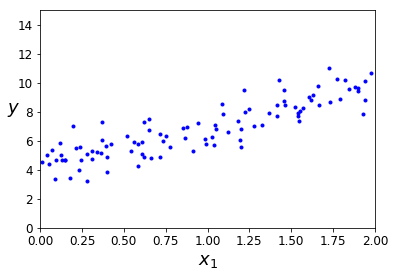

In [2]:
import numpy as np
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
#save_fig("generated_data_plot")
plt.show()

Now let’s compute using the Normal Equation. We will use the `inv()` function from NumPy’s Linear
Algebra module (`np.linalg`) to compute the inverse of a matrix, and the `dot()` method for matrix multiplication:

In [0]:
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

The actual function that we used to generate the data is $y = 4 + 3*x_0 + GaussianNoise$. Let’s see what the
equation found:

In [4]:
theta_best

array([[4.21509616],
       [2.77011339]])

We would have hoped for  \$θ_0 = 4$  and
$θ_1 = 3$ instead of $a_0 =  4.215$ and
$θ_1 = 2.770$.

Close enough, but the noise made it impossible to recover the exact parameters of the original function.


In [5]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

Now, let's do the same thing the Scikit-Learn way:

In [24]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
print("y = {0} + {1}*x".format(np.float(lin_reg.intercept_), np.float(lin_reg.coef_)))

X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)


y = 4.215096157546746 + 2.770113386438484*x


We can now plot the result:

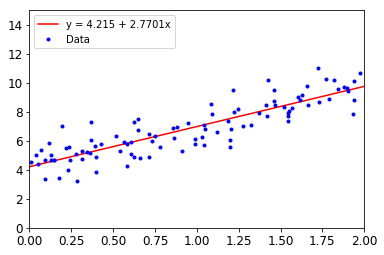

In [22]:
plt.plot(X_new, y_predict, "r-", label="y = 4.215 + 2.7701x")
plt.plot(X, y, "b.", label="Data")
plt.legend(loc="upper left")
plt.axis([0, 2, 0, 15])
plt.show()

#2. Polynomial Regression


What if our data is actually more complex than a simple straight line? Surprisingly, we can actually use
a linear model to fit nonlinear data. A simple way to do this is to add powers of each feature as new
features, then train a linear model on this extended set of features. This technique is called ***Polynomial Regression***.
Let’s look at an example. First, let’s generate some nonlinear data, based on a simple quadratic equation plus some noise:

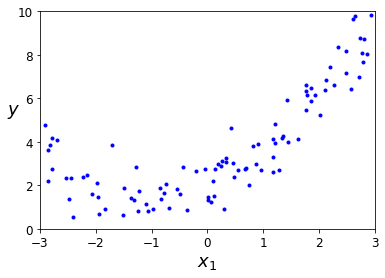

In [36]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
#save_fig("generated_data_plot")
plt.show()

Clearly, a straight line will never fit this data properly. So let’s use Scikit-Learn’s **`PolynomialFeatures`**
class to transform our training data, adding the square (2nd-degree polynomial) of each feature in the
training set as new features (in this case there is just one feature):

In [37]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([1.76886782])

`X_poly` now contains the original feature of X plus the square of this feature. Now you can fit a `LinearRegression` model to this extended training data:

In [38]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.99958228]), array([[1.04630034, 0.5015459 ]]))

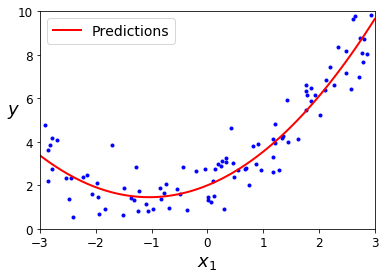

In [39]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
#save_fig("quadratic_predictions_plot")
plt.show()

Not bad: the model estimates $y = 1.9996 + 1.0463 x + 0.5015x^2 $ when in fact the original function was $y = 2 + x + 0.5 x^2$

Note that when there are multiple features, Polynomial Regression is capable of finding relationships
between features (which is something a plain Linear Regression model cannot do). This is made possible
by the fact that PolynomialFeatures also adds all combinations of features up to the given degree. For
example, if there were two features a and b, `PolynomialFeatures` with degree=3 would not only add the features $a^2, a^3, b^2, \ and \ b^3$, but also the combinations $ab, a^2b \ and \ ab^2$.

#Learning curves

How can we decide how complex our model should be? How can we tell
that your model is overfitting or underfitting the data?
In the Multivariate regression section we used cross-validation to get an estimate of a model’s generalization performance. 

**If a
model performs well on the training data but generalizes poorly according to the cross-validation metrics, then our model is overfitting. If it performs poorly on both, then it is underfitting.** 

This is one way to tell
when a model is too simple or too complex.


Another way is to look at the learning curves: these are plots of the model’s performance on the training
set and the validation set as a function of the training set size. To generate the plots, simply train the model
several times on different sized subsets of the training set. 

The following code defines a function that plots
the learning curves of a model given some training data:

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
  
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
  train_errors, val_errors = [], []
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
    val_errors.append(mean_squared_error(y_val_predict, y_val))
  plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
  plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
  plt.axis([0, 80, 0, 3])                         # not shown in the book
  #save_fig("underfitting_learning_curves_plot")   # not shown
  plt.legend(loc="upper right", fontsize=14)   # not shown in the book
  plt.xlabel("Training set size", fontsize=14) # not shown
  plt.ylabel("RMSE", fontsize=14)              # not shown
  plt.show()                                      # not shown


##Underfitting the model

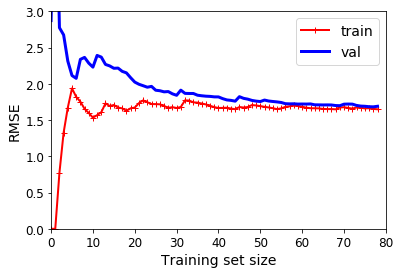

In [45]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)


This deserves a bit of explanation. First, let’s look at the performance on the training data: when there are
just one or two instances in the training set, the model can fit them perfectly, which is why the curve starts
at zero. But as new instances are added to the training set, it becomes impossible for the model to fit the
training data perfectly, both because the data is noisy and because it is not linear at all. So the error on the
training data goes up until it reaches a plateau, at which point adding new instances to the training set
doesn’t make the average error much better or worse. Now let’s look at the performance of the model on
the validation data. When the model is trained on very few training instances, it is incapable of
generalizing properly, which is why the validation error is initially quite big. Then as the model is shown
more training examples, it learns and thus the validation error slowly goes down. 

However, once again a
straight line cannot do a good job modeling the data, so the error ends up at a plateau, very close to the
other curve.


These learning curves are typical of an underfitting model. Both curves have reached a plateau; they are
close and fairly high.

##Best fitting the model

Now let’s look at the learning curves of a 2nd-degree polynomial model on the same data, i.e. the model that best fits the data:

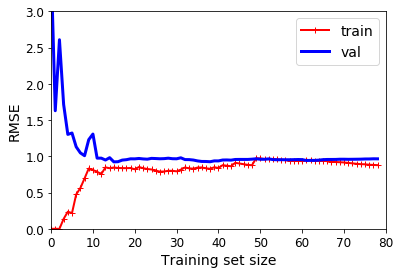

In [47]:
from sklearn.pipeline import Pipeline
polynomial_regression = Pipeline((
("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
("lin_reg", LinearRegression()),
))

plot_learning_curves(polynomial_regression, X, y)

This is how the chart for the best model should look like. Both curves cross with each other quite quickly and both tend to the minimum RMSE, which is around 1.



##Overfitting the model

Now let’s look at the learning curves of a 10th-degree polynomial model (an overfitting model) on the same data:

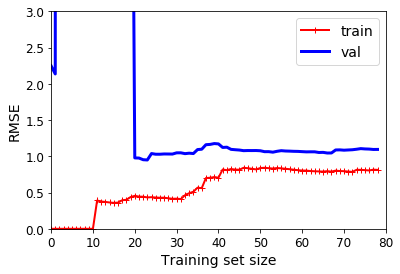

In [48]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline((
("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
("lin_reg", LinearRegression()),
))

plot_learning_curves(polynomial_regression, X, y)

These learning curves look a bit like the previous ones, but there are two very important differences:


*   The error on the training data is much lower than with the Linear Regression model (one degree polynomial).
*   **There is a gap between the curves**. This means that **the model performs significantly better on the
training data than on the validation data, which is the hallmark of an overfitting model**. However, if
you used a much larger training set, the two curves would continue to get closer.